# <center> Previsão do PLD semanal para o Subsistema Nordeste. </center>

### Os dados foram coletados diretamente do site do [ONS](https://www.ons.org.br/paginas/resultados-da-operacao/historico-da-operacao/dados-gerais). O período escolhido foi de junho/2020 a junho/2023, em base semanal.


In [98]:
import pandas as pd

df = pd.read_excel('Dados_ONS.xlsx')
df.head()

,Semana,ENA Bruta (MWmed),Carga de Energia (MWmed),Eólica (MWmed),Solar (MWmed),Térmica (MWmed),EAR (MWmed),CMO(R$/MWh)
0,2020-06-06,3888,9428,5147.239238,444.795673,518.520339,205011.904762,0.00
1,2020-06-13,3259,9396,6553.801077,430.255792,581.647994,204023.809524,88.25
2,2020-06-20,3022,9385,7023.432512,418.438679,633.813536,202238.095238,91.98
3,2020-06-27,2825,9548,5310.612988,498.462256,514.870042,200113.095238,88.62
4,2020-07-04,2626,9570,5785.222643,410.391345,572.965423,197321.428571,81.88


In [3]:
#Para cada ano, há um PLD mínimo e máximo definido pelo CCEE (Câmara de Comercialização de Energia Elétrica).
#Portanto, para valores de CMO inferiores ao PLD mínimo, será considerado o PLD mínimo. Por conseguinte, para valores superiores ao PLD máximo, será considerado o PLD máximo.

def modify_cmo(row):
    year = row['Semana'].year
    cmo = row['CMO(R$/MWh)']
    
    if year == 2020:
        if cmo < 39.68:
            return 39.68
        if cmo > 556.58:
            return 556.58
    elif year == 2021:
        if cmo < 49.77:
            return 49.77
        if cmo > 583.88:
            return 583.88
    elif year == 2022:
        if cmo < 55.70:
            return 55.70
        if cmo > 640.70:
            return 640.70
    elif year == 2023:
        if cmo < 69.04:
            return 69.04
        if cmo > 678.29:
            return 678.29
    
    return cmo


df['CMO(R$/MWh)'] = df.apply(lambda row: modify_cmo(row), axis=1)
df.set_index(['Semana'], inplace = True)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2020-06-06 to 2023-07-01
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ENA Bruta (MWmed)         161 non-null    int64  
 1   Carga de Energia (MWmed)  161 non-null    int64  
 2   Eólica (MWmed)            161 non-null    float64
 3   Solar (MWmed)             161 non-null    float64
 4   Térmica (MWmed)           161 non-null    float64
 5   EAR (MWmed)               161 non-null    float64
 6   CMO(R$/MWh)               161 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 10.1 KB


#### Não há nenhum valor nulo, não sendo necessária a manipulação de valores.

## Análise de outliers

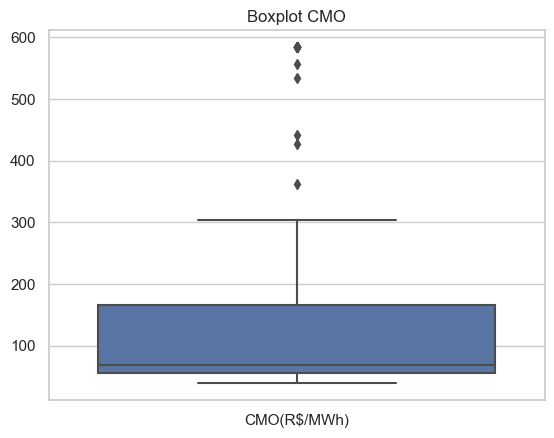

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.switch_backend('module://ipykernel.pylab.backend_inline')
sns.set(style="whitegrid")

sns.boxplot(df[["CMO(R$/MWh)"]])
plt.title('Boxplot CMO')
plt.show()

### É possível observar a presença de outliers. A manipulação deles se dará conforme necessidade.

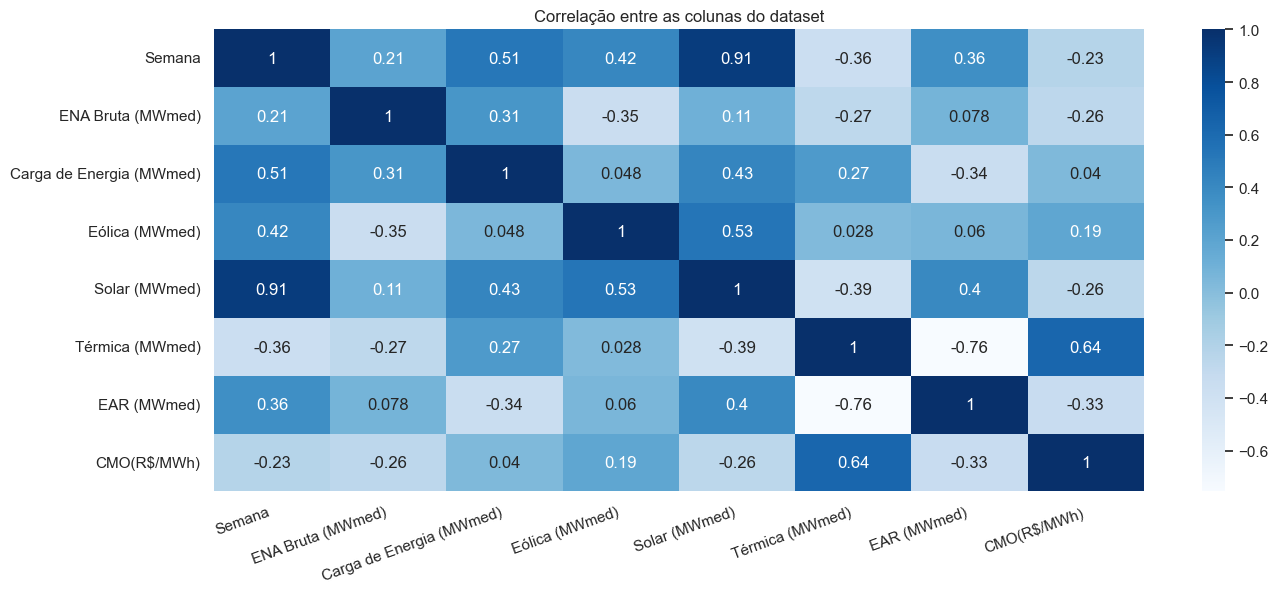

In [122]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True, cmap="Blues")
plt.title('Correlação entre as colunas do dataset')
plt.xticks(rotation=20, ha='right')
plt.show()

### Análise a partir do gráfico de correlação:
- Quando o EAR (energia armazenada) está com um valor baixo, a geração térmica precisa compensar a falta de geração hidráulica, devido a baixa capacidade de armazenamento de energia da bacia. Vale ressaltar que nem sempre a geração solar conseguirá compensar, já que é uma fonte intermitente e necessita da presença do sol. Por isso que sua correlação não está tão alta com o EAR.
- Por serem fontes intermitentes, a geração solar e eólica não são armazenadas. Portanto, durante o período diurno, elas têm prioridade na geração de energia. Isso é demonstrado pela correlação positiva moderada.
- Por ser uma fonte de alto custo, quando é utilizada a geração térmica, o preço do CMO aumenta.

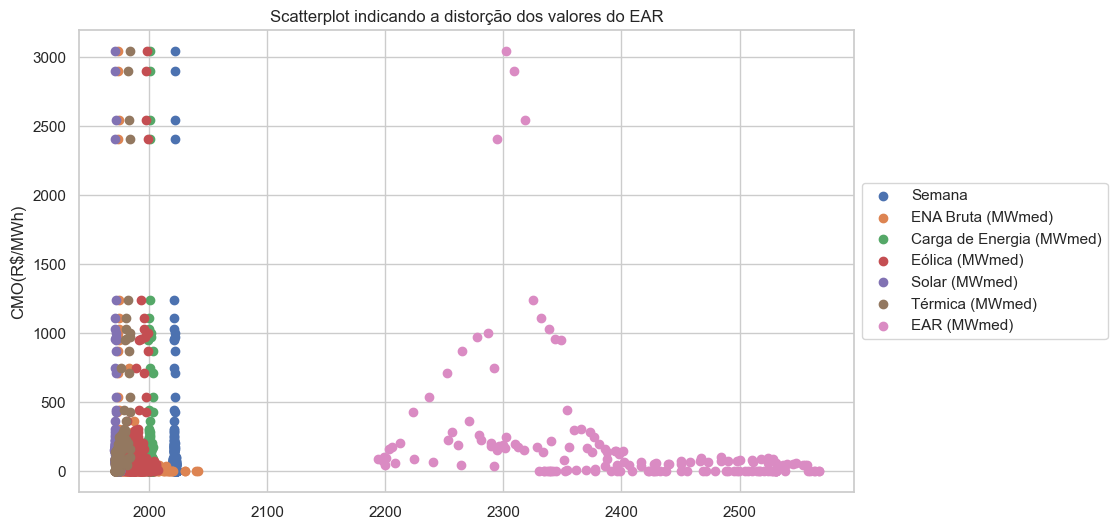

In [130]:
plt.figure(figsize=(10, 6))
y = df["CMO(R$/MWh)"]
a = df.drop("CMO(R$/MWh)", axis=1)
for i, column in enumerate(a.columns):
    x = df[column]
    plt.scatter(x, y, label=column)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("CMO(R$/MWh)")
plt.title('Scatterplot indicando a distorção dos valores do EAR')
plt.show()

### Os valores de EAR destoam dos outros, tornando-se obrigatória a normalização para alguns modelos de ML.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, max_error, explained_variance_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor

test_size = 0.30 
random_state = 42

y = df["CMO(R$/MWh)"]
x = df.drop("CMO(R$/MWh)", axis=1)

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=test_size, random_state=random_state)

## REGRESSÃO LINEAR

In [67]:
#MODELO DE REGRESSÃO LINEAR

modelo_regressaolinear = LinearRegression()
modelo_regressaolinear.fit(x_treino, y_treino)
previsao_regressaolinear = modelo_regressaolinear.predict(x_teste)

#Métricas de erro
mse_regressaolinear = mean_squared_error(y_teste, previsao_regressaolinear)
rmse_regressaolinear = mean_squared_error(y_teste, previsao_regressaolinear, squared=False)
mae_regressaolinear = mean_absolute_error(y_teste, previsao_regressaolinear)
evs_regressaolinear = explained_variance_score(y_teste, previsao_regressaolinear)
medae_regressaolinear = median_absolute_error(y_teste, previsao_regressaolinear)
me_regressaolinear = max_error(y_teste, previsao_regressaolinear)
r2_regressaolinear = metrics.r2_score(y_teste, previsao_regressaolinear)

RL_Metrics = [r2_regressaolinear, mse_regressaolinear, rmse_regressaolinear, mae_regressaolinear, evs_regressaolinear, medae_regressaolinear, me_regressaolinear]

print("Regressão linear:", "R2 Score:", metrics.r2_score(y_teste, previsao_regressaolinear))
print("Mean Squared Error (MSE):", mse_regressaolinear)
print("Root Mean Squared Error (RMSE):", rmse_regressaolinear)
print("Mean Absolute Error (MAE):", mae_regressaolinear)
print("Explained Variance Score (EVS):", evs_regressaolinear)
print("Median Absolute Error (MedAE):", medae_regressaolinear)
print("Max Error (ME):", me_regressaolinear)

Regressão linear: R2 Score: 0.6855425497939529
Mean Squared Error (MSE): 7594.68426423503
Root Mean Squared Error (RMSE): 87.14748570231404
Mean Absolute Error (MAE): 67.47355665121238
Explained Variance Score (EVS): 0.6862534550871983
Median Absolute Error (MedAE): 57.83922340077213
Max Error (ME): 276.6327088304838


## ÁRVORE DE DECISÃO

In [68]:
#MODELO DE ÁRVORE DE DECISÃO

modelo_arvoredecisao = RandomForestRegressor()
modelo_arvoredecisao.fit(x_treino, y_treino)
previsao_arvoredecisao = modelo_arvoredecisao.predict(x_teste)

#Métricas de erro
mse_ad = mean_squared_error(y_teste, previsao_arvoredecisao)
rmse_ad = mean_squared_error(y_teste, previsao_arvoredecisao, squared=False)
mae_ad = mean_absolute_error(y_teste, previsao_arvoredecisao)
evs_ad = explained_variance_score(y_teste, previsao_arvoredecisao)
medae_ad = median_absolute_error(y_teste, previsao_arvoredecisao)
me_ad = max_error(y_teste, previsao_arvoredecisao)
r2_ad = metrics.r2_score(y_teste, previsao_arvoredecisao)

AD_Metrics = [r2_ad, mse_ad, rmse_ad, mae_ad, evs_ad, medae_ad, me_ad]

print("Arvore de decisão:", "R2 Score:", r2_ad)
print("Mean Squared Error (MSE):", mse_ad)
print("Root Mean Squared Error (RMSE):", rmse_ad)
print("Mean Absolute Error (MAE):", mae_ad)
print("Explained Variance Score (EVS):", evs_ad)
print("Median Absolute Error (MedAE):", medae_ad)
print("Max Error (ME):", me_ad)

Arvore de decisão: R2 Score: 0.7234128611488978
Mean Squared Error (MSE): 6680.051592817565
Root Mean Squared Error (RMSE): 81.73158259092726
Mean Absolute Error (MAE): 44.99613061224495
Explained Variance Score (EVS): 0.7349895933702315
Median Absolute Error (MedAE): 10.863199999999964
Max Error (ME): 302.57660000000044


# RANDOM FOREST REGRESSOR 

In [70]:
#MODELO DE RANDOM FOREST REGRESSOR

modelo_randomforest = RandomForestRegressor()
modelo_randomforest.fit(x_treino, y_treino)
previsao_randomforest = modelo_randomforest.predict(x_teste)

# Métricas de erro
mse_rf = mean_squared_error(y_teste, previsao_randomforest)
rmse_rf = mean_squared_error(y_teste, previsao_randomforest, squared=False)
mae_rf = mean_absolute_error(y_teste, previsao_randomforest)
evs_rf = explained_variance_score(y_teste, previsao_randomforest)
medae_rf = median_absolute_error(y_teste, previsao_randomforest)
me_rf = max_error(y_teste, previsao_randomforest)
r2_rf = metrics.r2_score(y_teste, previsao_randomforest)

RF_Metrics = [r2_rf, mse_rf, rmse_rf, mae_rf, evs_rf, medae_rf, me_rf]

print("Random Forest Regressor:", "R2 Score:", r2_rf)
print("Mean Squared Error (MSE):", mse_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("Mean Absolute Error (MAE):", mae_rf)
print("Explained Variance Score (EVS):", evs_rf)
print("Median Absolute Error (MedAE):", medae_rf)
print("Max Error (ME):", me_rf)

Random Forest Regressor: R2 Score: 0.6874636600860566
Mean Squared Error (MSE): 7548.286170961235
Root Mean Squared Error (RMSE): 86.88087344727397
Mean Absolute Error (MAE): 46.87071428571433
Explained Variance Score (EVS): 0.7002619580980392
Median Absolute Error (MedAE): 11.38719999999995
Max Error (ME): 340.91530000000023


## SVR LINEAR

In [72]:
#MODELO DE SVR LINEAR

svr_linear = make_pipeline(StandardScaler(), SVR(kernel='linear'))
svr_linear.fit(x_treino, y_treino)
previsao_svr_linear = svr_linear.predict(x_teste)

#Métricas de erro
mse_svr_l = mean_squared_error(y_teste, previsao_svr_linear)
rmse_svr_l = mean_squared_error(y_teste, previsao_svr_linear, squared=False)
mae_svr_l = mean_absolute_error(y_teste, previsao_svr_linear)
evs_svr_l = explained_variance_score(y_teste, previsao_svr_linear)
medae_svr_l = median_absolute_error(y_teste, previsao_svr_linear)
me_svr_l = max_error(y_teste, previsao_svr_linear)
r2_svr_l = metrics.r2_score(y_teste, previsao_svr_linear)

SVR_Metrics = [r2_svr_l, mse_svr_l, rmse_svr_l, mae_svr_l, evs_svr_l, medae_svr_l, me_svr_l]

print("SVR linear:", "R2 Score:", r2_svr_l)
print("Mean Squared Error (MSE):", mse_svr_l)
print("Root Mean Squared Error (RMSE):", rmse_svr_l)
print("Mean Absolute Error (MAE):", mae_svr_l)
print("Explained Variance Score (EVS):", evs_svr_l)
print("Median Absolute Error (MedAE):", medae_svr_l)
print("Max Error (ME):", me_svr_l)

SVR linear: R2 Score: 0.27112242844698575
Mean Squared Error (MSE): 17603.63769279545
Root Mean Squared Error (RMSE): 132.6787009764395
Mean Absolute Error (MAE): 74.06298079743927
Explained Variance Score (EVS): 0.3394223606307808
Median Absolute Error (MedAE): 33.59058082926161
Max Error (ME): 428.06964891576115


## MLPREGRESSOR (REDES NEURAIS)

In [73]:
import pickle


#MODELO DE MLPREGRESSOR (REDES NEURAIS)

#Para a criação do modelo, foi utilizado o código abaixo. Ele está comentado pois o MLPRegressor foi o melhor modelo e, portanto, foi salvo no final via Pickle. 

#nn_r = make_pipeline(MinMaxScaler(), MLPRegressor(max_iter=1000, solver='adam', alpha=0.1, learning_rate_init=0.01))
#nn_r.named_steps['mlpregressor'].hidden_layer_sizes = (100, 50, 10)
#nn_r.fit(x_treino, y_treino)

nn_r = pickle.load(open('MLPRegressor-PLD.pkl', 'rb')) #Recuperando o modelo salvo
previsao_nn = nn_r.predict(x_teste)

#Métricas de erro
mse_nn = mean_squared_error(y_teste, previsao_nn)
rmse_nn = mean_squared_error(y_teste, previsao_nn, squared=False)
mae_nn = mean_absolute_error(y_teste, previsao_nn)
evs_nn = explained_variance_score(y_teste, previsao_nn)
medae_nn = median_absolute_error(y_teste, previsao_nn)
me_nn = max_error(y_teste, previsao_nn)
r2_nn = metrics.r2_score(y_teste, previsao_nn)

MLP_Metrics = [r2_nn, mse_nn, rmse_nn, mae_nn, evs_nn, medae_nn, me_nn]

print("Rede Neural:", "R2 Score:", r2_nn)
print("Mean Squared Error (MSE):", mse_nn)
print("Root Mean Squared Error (RMSE):", rmse_nn)
print("Mean Absolute Error (MAE):", mae_nn)
print("Explained Variance Score (EVS):", evs_nn)
print("Median Absolute Error (MedAE):", medae_nn)
print("Max Error (ME):", me_nn)

Rede Neural: R2 Score: 0.8619474248981869
Mean Squared Error (MSE): 3334.2053720649997
Root Mean Squared Error (RMSE): 57.74257850204648
Mean Absolute Error (MAE): 33.049699726389164
Explained Variance Score (EVS): 0.8622147269646847
Median Absolute Error (MedAE): 9.688916091048114
Max Error (ME): 238.11638847942868


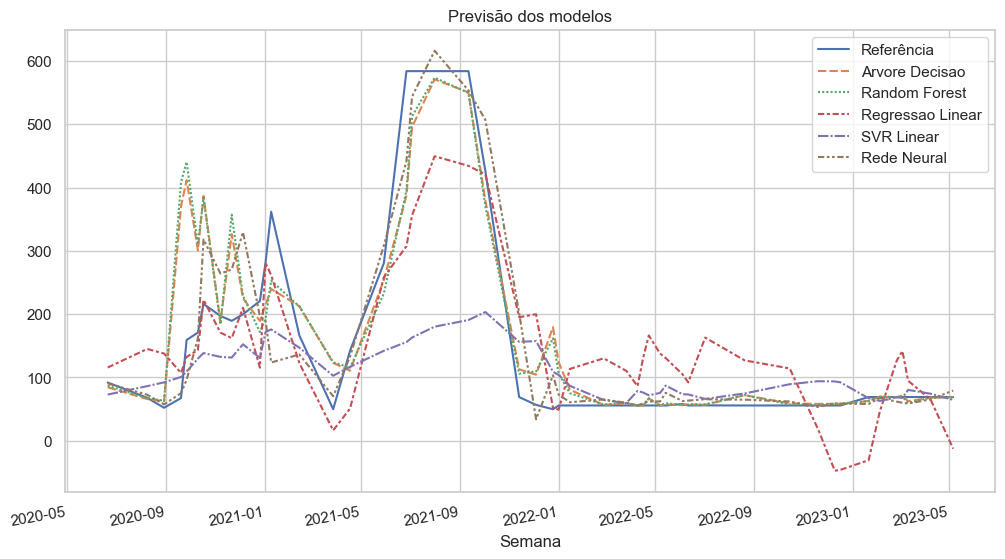

In [93]:
df_predict = pd.DataFrame()
df_predict["Referência"] = y_teste
df_predict["Arvore Decisao"] = previsao_arvoredecisao
df_predict["Random Forest"] = previsao_randomforest
df_predict["Regressao Linear"] = previsao_regressaolinear
df_predict["SVR Linear"] = previsao_svr_linear
df_predict["Rede Neural"] = previsao_nn

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_predict)
plt.title('Previsão dos modelos')
plt.xticks(rotation=10, ha='right')
plt.show()


In [78]:
metrics_dict = {'Regressão Linear': RL_Metrics, 'Árvore de Decisão': AD_Metrics, 'Random Forest': RF_Metrics, 'SVR Linear': SVR_Metrics, 'Redes Neurais': MLP_Metrics}
metrics_index = ['R2 Score', 'MSE', 'RMSE', 'MAE', 'EVS', 'MedAE', 'ME']
df_metrics = pd.DataFrame(metrics_dict)
df_metrics["Métricas"] = metrics_index
df_metrics.set_index("Métricas", inplace=True)


df_metrics

,Regressão Linear,Árvore de Decisão,Random Forest,SVR Linear,Redes Neurais
Métricas,,,,,
R2 Score,0.685543,0.723413,0.687464,0.271122,0.861947
MSE,7594.684264,6680.051593,7548.286171,17603.637693,3334.205372
RMSE,87.147486,81.731583,86.880873,132.678701,57.742579
MAE,67.473557,44.996131,46.870714,74.062981,33.049700
EVS,0.686253,0.734990,0.700262,0.339422,0.862215
MedAE,57.839223,10.863200,11.387200,33.590581,9.688916
ME,276.632709,302.576600,340.915300,428.069649,238.116388


### Como é possível observar na tabela acima, o modelo baseado em Redes Neurais obteve a melhor performance. As métricas mais relevantes são: R2 Score e RMSE.
- R2 Score: Quanto mais próximo de 1, melhor o gráfico acompanha a curva de referência. 
- RMSE: Quanto menor esse valor, mais eficaz o modelo consegue prever os valores desejados. Isso acontece pois essa métrica penaliza de maneira significativa os erros maiores, permitindo que o modelo tenha a tendência de minimizar os erros para uma ampla gama de valores.

# Adição das métricas específicas para o melhor modelo (Redes Neurais)

In [96]:
df_predict = pd.DataFrame()
df_predict = pd.concat([df_predict, x_teste])
df_predict["Referência"] = y_teste
df_predict["Previsão Rede Neural"] = previsao_nn

# Erro relativo por linha (em módulo)

In [80]:
df_predict["Erro Relativo (%)"] = ((df_predict["Previsão Rede Neural"]-df_predict["Referência"])/df_predict["Referência"])*100

In [81]:
import numpy as np
modulo_erro = df_predict["Erro Relativo (%)"]**2
modulo_erro = np.sqrt(modulo_erro)
print(f"Média do erro relativo absoluto: {modulo_erro.mean():.2f}%")

Média do erro relativo absoluto: 23.28%


# Trend

In [85]:
for i, row in df_predict.iterrows():
    valor_real = row['Eólica (MWmed)']  # Pegar um valor único da coluna
    semana_atual = df.loc[df['Eólica (MWmed)'] == valor_real]
    semana_anterior = df.loc[df['Eólica (MWmed)'].shift(-1) == valor_real]
    
    semana_atual.reset_index(drop=True, inplace=True)
    semana_anterior.reset_index(drop=True, inplace=True)
    
    #Compara o CMO dessa semana com a da semana anterior na tabela completa
    if semana_anterior["CMO(R$/MWh)"].iloc[0] > semana_atual["CMO(R$/MWh)"].iloc[0]:
        df_predict.at[i, "Trend"] = df_predict.at[i, "Previsão Rede Neural"] < semana_anterior["CMO(R$/MWh)"].iloc[0]
    elif semana_anterior["CMO(R$/MWh)"].iloc[0] < semana_atual["CMO(R$/MWh)"].iloc[0]:
        df_predict.at[i, "Trend"] = df_predict.at[i, "Previsão Rede Neural"] > semana_anterior["CMO(R$/MWh)"].iloc[0]
    else:
        df_predict.at[i, "Trend"] = (df_predict.at[i, "Erro Relativo (%)"] < 10) and (df_predict.at[i, "Erro Relativo (%)"] > -10)


In [86]:
df_predict["Trend"].value_counts()

Trend
True     31
False    18
Name: count, dtype: int64

#### Essa métrica analisa se a previsão é de subida ou de descida do valor do PLD com relação à semana anterior. Dessa forma, caso a trend de subida ou de descida seja convergente entre a previsão do modelo e o valor de referência, a variável booleana True é informada. Caso contrário, a variável booleana False é informada. Caso o valor da semana anterior seja igual à da semana atual, o valor previsto será comparado com uma margem de 10% de erro relativo ao valor real, considerando convergência se o valor previsto estiver dentro dessa margem. 

### O modelo acertou a trend em 63% (31 das 49 semanas).


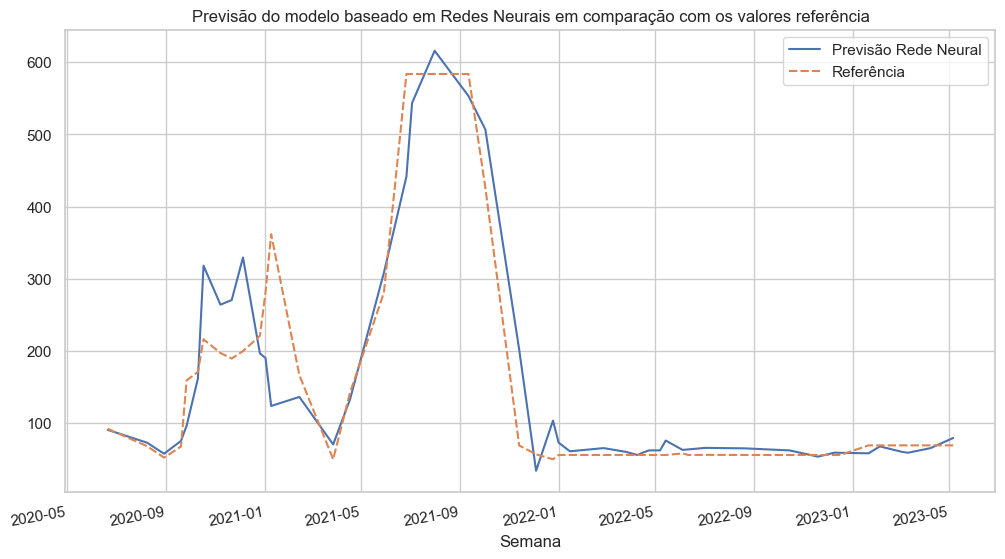

In [99]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_predict[["Previsão Rede Neural", "Referência"]])
plt.title('Previsão do modelo baseado em Redes Neurais em comparação com os valores referência')
plt.xticks(rotation=10, ha='right')
plt.show()
plt.show()

# Exportando o modelo

In [42]:
with open('MLPRegressor-PLD.pkl', 'wb') as file:
    pickle.dump(nn_r, file)